<a href="https://colab.research.google.com/github/PBPZA/ml_uwr/blob/fall2019/lectures/05_adabost_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [0]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn import linear_model, tree, svm, datasets, model_selection

import seaborn as sns

In [0]:
#@title Utility funs

def get_grid(X):
    Grid = np.meshgrid(np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, 50), 
                       np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, 50))
    XGridFlat = np.concatenate((Grid[0].reshape(-1, 1),
                                Grid[1].reshape(-1, 1)), axis=-1)
    return Grid, XGridFlat


def plot_data(X, Y, W=None, 
              XGrid=None, YGrid=None):
    pal2 = sns.color_palette("Set1")[:2]
    if XGrid is not None:
        plt.contourf(XGrid[0], XGrid[1], YGrid.reshape(XGrid[0].shape),
                    cmap='Set1', vmin=-1, vmax=9, alpha=0.7)
    sns.scatterplot(x=X[:,0], y=X[:,1], size=W, hue=Y, palette=pal2)
    plt.axis('square')
    plt.xlim(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1)
    plt.ylim(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1)

    # Remove size from legend
    ax = plt.gca()
    # EXTRACT CURRENT HANDLES AND LABELS
    h,l = ax.get_legend_handles_labels()

    # COLOR LEGEND (FIRST 30 ITEMS)
    col_lgd = plt.legend(h[:2], l[:2], loc='upper right')

# Adaboost

Adaboost is another popular meta-algorithm which creates a good classifier out of a mediocre one. While most frequently it is used with decision trees, it can be applied to any classifier.

## Boosting origins

Boosting classifiers began with a theoretical question:

> Is it possible to combine weak classifers (only slightly better than random guessing) into a strong classifer (error rate is arbitrarily low).

As such, boosting is not concerned with overfitting and reducing classifier variance, but with modleing complex decision boundaries when the available learners can only produce simple ones.

The core idea in adaboost is that we will be sequentilly building classifiers traind to **work well on samples misclassified by the previous ones**.

By forcing the classifiers to correct the mistakes performed by the previous ones, we can drive overall training error low.


## Boosting example

In the example below the weak learner is the Desicion Tree Stump (a tree with only one split). 

We train the first weak classifier on all data with uniform weights.

We then increase the weight of misclassified examples and decrease the weight of correctly classified ones. A new classifier is thus trained to pay more attention to the errors of the previous ones.

We can notice that the final decision boundary is impossible to express as a single Decision Tree Stump.


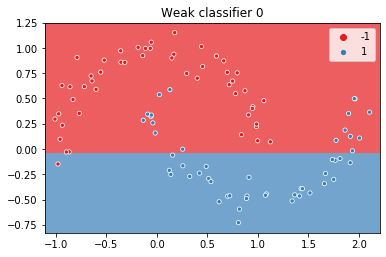

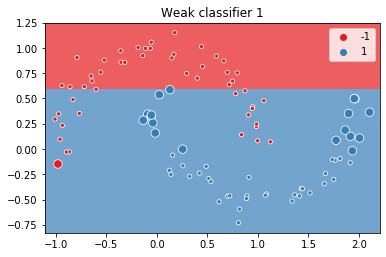

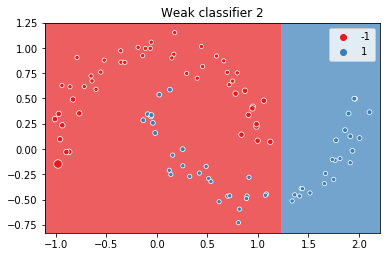

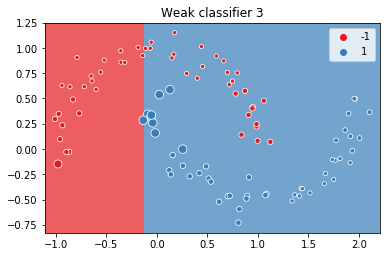

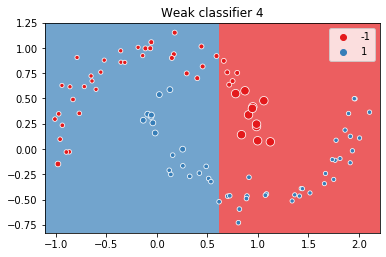

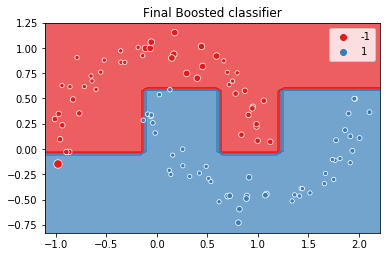

In [0]:
#@title Demo

# Moons data
X, Y = datasets.make_moons(noise=0.1)
Y = Y * 2 - 1

T = 5
W = np.ones(Y.shape)

XGrid, XGridFlat = get_grid(X)
grid_scores = 0
Y_scores = 0

H = []
train_errs = []

for t in range(T):
    f_t = tree.DecisionTreeClassifier(
        max_depth=1).fit(X, Y, W)
    err_t = ((f_t.predict(X) != Y) * W).mean()
    alpha_t = .5 * np.log((1-err_t) / err_t)

    plt.figure()
    plot_data(X, Y, W, XGrid, f_t.predict(XGridFlat))
    plt.title(f'Weak classifier {t}')

    W *= np.exp(- alpha_t * Y  * f_t.predict(X))
    #W /= W.sum() / Y.shape[0]

    grid_scores += alpha_t * f_t.predict(XGridFlat)
    
plt.figure()
plot_data(X, Y, W, XGrid, np.sign(grid_scores))
plt.title(f'Final Boosted classifier')
None

## Adabost Details
Mostly based on Rojas http://www.inf.fu-berlin.de/inst/ag-ki/adaboost4.pdf

We will discuss setting with binary classes. Assume that we are given a training set $S := \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$ where  $(\forall i \in \{1,...,n\})$$(y_i \in \{ -1, 1 \})$ and a set $\mathcal{H}$ of hypothesis functions (aka weak classifiers) from which we want to pick $T$ hypotheses to form a boosted classifier $f_T$, which is a linear combination of the decisions of each of the chosen hypotheses. The decision about data point's class is then made by looking at sign of $f_T$:
$$f_T(x) = \sum_{t = 1}^{T} \gamma_{t}h_t(x)$$
$$H(x) = sign(f_T)$$
The AdaBoost algorithm sequentially chooses $h_t$ from $\mathcal{H}$ and assigns this hypothesis a weight $\gamma_{t}$.

After the first $(t-1)$-th iterations we have $f_{t-1}(x) = \sum_{k=1}^{t-1}\gamma_{k}h_{k}$. At the $t$-th iteration we want to add add another $h_t$ with weight $\gamma_t$ such that our boosted classifier is better. We know how to choose them from what follows:

Let's define the total error $E$ of $f_t$ as the sum of its exponential loss on each data point:
$\begin{align*}
E &= \sum_{i = 1}^{n}e^{-y_{i}f_{t}(x_i)} \\
 &= \sum_{i = 1}^{n}e^{-y_{i}f_{t-1}(x_i)}e^{-y_{i}\gamma_{t}h_{k}} && \text{by unwrapping } f_t \\
& = \sum_{i=1}^{n}w_{i}^{(t)}e^{-y_{i}\gamma_{t}h_{t}} && \text{let } w_{i}^{(1)} = \frac{1}{n} \text{ and } w_{i}^{(t)} = e^{-y_{i}f_{t-1}(x_{i})} \\
 &= \sum_{y_{i}=h_t(x_{i})}w_{i}^{(t)}e^{-\gamma_t}+\sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}e^{\gamma_t} && \text {split by correctly } (y_{i}h_{t}(x_{i}) = 1) \text { and incorrectly } (y_{i}h_{t}(x_{i}) = -1)  \text { classified data points}\\
&= \sum_{y_{i}=h_t(x_{i})}w_{i}^{(t)}e^{-\gamma_t}+ \sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}e^{-\gamma_t} - \sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}e^{-\gamma_t} + \sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}e^{\gamma_t} && \text{add and subtract } \sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}e^{-\gamma_t} \\
&= \sum_{i = 1}^{n}w_{i}^{(t)}e^{-\gamma_t} + \sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}(e^{\gamma_t} - e^{-\gamma_t}) && \text{group first sum with second and third with fourth}
\end{align*}$



We are seeking $h_t$ that minimizes $E$. But only the $\sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}$ depends on $h_t$, so the best classifier is the one that minimizes this sum. 

The best weight we get by solving for $\gamma_t$ the expression $\frac{dE}{d\gamma_t}=0$


$\begin{align*}
\frac{dE}{d\gamma_t} = & -\sum_{y_{i}=h_t(x_{i})}w_{i}^{(t)}e^{-\gamma_t}+\sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}e^{\gamma_t}\\
& -\sum_{y_{i}=h_t(x_{i})}w_{i}^{(t)}e^{-\gamma_t}+\sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}e^{\gamma_t} &= 0 \\
& -\sum_{y_{i}=h_t(x_{i})}w_{i}^{(t)}+\sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}e^{2\gamma_t} &=0 && \text{multiply both sides by } e^{\gamma_t}
\end{align*}$



So by solving for $\gamma_t$ we get
$$\gamma_t = \frac{1}{2}\ln\left(\frac{\sum_{y_{i}=h_t(x_{i})}w_{i}^{(t)}}{\sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}} \right)$$
In the rest of this notebook we are calling the rate of errors given the weights $\frac{\sum_{y_{i}\neq h_{t}(x_{i})}w_{i}^{(t)}}{\sum_{i = 1}^{n}w_{i}^{(t)}}$ as $\epsilon_t$ and so we can rewrite the above as
$$\frac{1}{2}\ln \left( \frac{1 - \epsilon_t}{\epsilon_t} \right)$$



##Pseudocode
Set initial weights $w_i^{(1)}=\frac{1}{n}$ to all data points $x_i$

For $t = 1$ to $T$

1.   Select from $\mathcal{H}$ the classifier $h_t$ which minimizes 
$$\sum_{y_i \neq h_t(x_i)}w_i^{(t)}$$
2.   Set the weight $\gamma_t$ of the classifier to 
$$\gamma_t = \frac{1}{2} \ln\left( \frac{1 - \epsilon_t}{\epsilon_t}\right)$$
3. Update the weights to 
$$w_i^{(t+1)} = \frac{w_i^{(t)}e^{-y_i \gamma_t h_t(x_i)}}{Z_t}$$ for all $i$ where $Z_t$ is normalization constant to make $w_i^{(t)}$ a distribution, that is to have
$$\sum_i w_i^{(t+1)} = 1$$










## Proof of upper bound of error
We follow https://www.cs.princeton.edu/courses/archive/fall07/cos402/readings/boosting.pdf

Here we will prove that the training error of final classifier $H$ is at most $\exp \left( -2 \sum_{t=1}^{T} \left( \frac{1}{2} - \epsilon_t \right)^2 \right)$ 

Step 1: First we show that \
$$w_i^{(T+1)} =  \frac{e^{-y_i f_T (x_i)}}{n \prod_t Z_t}$$
Proof: the above can be rewritten as
$$w_i^{(t+1)} = \frac{w_i^t e^{-\gamma_ty_ih_t(x_1)}}{Z_t}$$ 
By unwrapping this recurrence we get

\begin{aligned}
w_i^{(T+1)} &=w_i^{(1)} \cdot \frac{e^{-\gamma_{1} y_{i} h_{1}\left(x_{i}\right)}}{Z_{1}} \cdots \cdot \frac{e^{ -\gamma_{T} y_{i} h_{T}\left(x_{i}\right)}}{Z_{T}} \\
&=\frac{1}{n} \cdot \frac{e^{ -y_{i} \sum_{t} \gamma_{t} h_{t}\left(x_{i}\right)}}{\prod_{t} Z_{t}} \\
&=\frac{1}{n} \cdot \frac{e^{ -y_{i} f_T\left(x_{i}\right)}}{\prod_{t} Z_{t}}
\end{aligned}
Step 2: Now we show that the training error of the final classifier $H$ is at most
$$\prod_{t=1}^{T}Z_t$$
Proof:


$\begin{align*}
 \text { training error }(H) &= \frac{1}{n} \sum_{i}\left\{\begin{array}{l}{1} &{\text { if } y_{i} \neq H\left(x_{i}\right) }
 \\ {0} &{\text { else }} \end{array}\right.
 && {\text {by definition of the training error}}
  \\ &= \frac{1}{n} \sum_{i}\left\{\begin{array}{l}{1} &{\text { if } y_{i}f(x_{i})\leq 0} 
\\{0} &{\text{ else }}    
\end{array}\right.
&& {\text {since } H(x) = sign(f(x)) \text{ and } y_i \in 
  \left\{ -1, +1 \right\} } 
\\ &\leq \frac{1}{n} \sum_{i}\begin{array}{l} 
e^{-y_if \left(x_i\right)}
  \end{array} 
  && \text{since } e^{-z} \geq 1 \text{ if } z\leq{0}
  \\ &= \sum_{i} w_i^{(T+1)}\prod_tZ_t &&  \text{by Step 1 above}
  \\ &=\prod_tZ_t &&{\text{since }w^{(T+1)} \text{is a distribution}}
\end{align*}$

Step 3: The last step is to compute $Z_t$

$\begin{align*}
Z_t &= \sum_{i} w_i^{(t)} \times  \left\{ \begin{array}{l} 
{e^{-\gamma_{t}}} & \text{if } h_{t}(x_{i}) = y_{i} \\
{e^{\gamma_{t}}} & \text{if } h_{t}(x_{i}) \neq y_{i}
\end{array} \right.\\
&= \sum_{y_i = h_t(x_i)}w_{i}^{(t)}e^{-\gamma_t} + \sum_{y_i \neq h_t(x_i)}w_i^{(t)}e^{\gamma_t}\\
&= e^{-\gamma_t} \sum_{y_i = h_t(x_i)}w_i^{(t)} + e^{\gamma_t} \sum_{y_i = h_t(x_i)} w_i^{(t)}\\
&= e^{-\gamma_t}(1 - \epsilon_t) + e^{\gamma_t} \epsilon_t && \text{by definition of } \epsilon_t\\
&= e^{-\frac{1}{2} \ln( \frac{1 - \epsilon_t} {\epsilon_t}) } (1 - \epsilon_t) + e^{\frac{1}{2} \ln(\frac{1 - \epsilon_t}{\epsilon_t})} \epsilon_t && \text {by our choice of } \gamma_t\\
&= \sqrt{\frac{\epsilon_t}{1 - \epsilon_t}} (1 - \epsilon_t) + \sqrt{\frac{1 - \epsilon_t}{\epsilon_t}} \epsilon_t \\
&= 2 \sqrt{\epsilon_t (1 - \epsilon_t)}\\
&= \sqrt{1 - 4 \alpha_t^2} && \text{plugging in } \epsilon_t = \frac{1}{2} - \alpha_t \\
&\leq \sqrt{e^{-4 \alpha_t^2}} && \text{using } 1+x \leq e^x \text{ for all real } x \\
&= e^{-2 \alpha_t^2} \\
&= e^{-2 \left(\frac{1}{2} - \epsilon_t\right)^2}
\end{align*}$

And combining all of the above we have

$\begin{align*}
\text {training error}(H) &=\prod_t Z_t = \prod_t 2 \sqrt{\epsilon_t (1 - \epsilon_t)} \leq \prod_t e^{-2 (\frac{1}{2} - \epsilon_t)^2} = \exp \left(-2 \sum_t \left(\frac{1}{2} - \epsilon_t \right)^2 \right)
\end{align*}$

As claimed.



## A larger demonstration

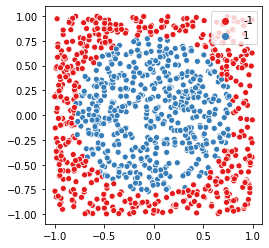

In [0]:
# Generate a nonlinearly separable dataset

# Circle dataset
X = np.random.rand(1000, 2) * 2 -1
Y = (X**2).sum(-1) < (2 / np.pi)
Y = Y * 2 - 1

# # Triangle data
# Y = X @ np.array(
#     [[1, 0],
#      [0, 1],
#      [-1, -1]
#      ]
# ).T + np.array([[+0.7, +0.7, +0.3]])
# Y = (Y > 0).all(-1) * 2.0 -1

# # Moons data
# X, Y = datasets.make_moons(noise=0.1)
# Y = Y * 2 - 1

plot_data(X, Y)

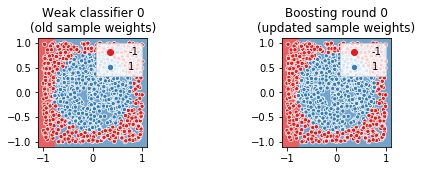

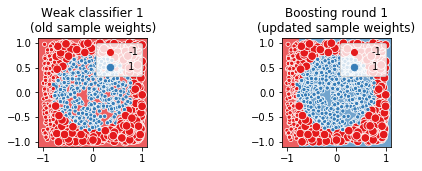

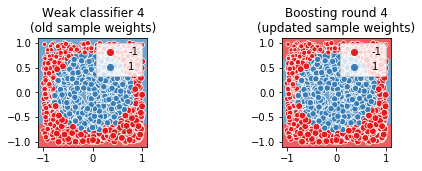

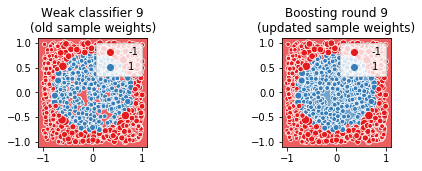

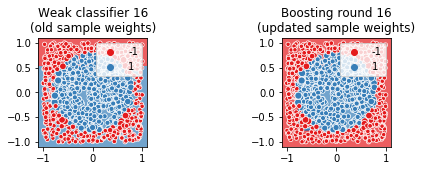

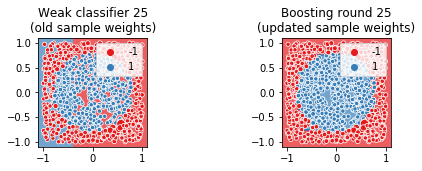

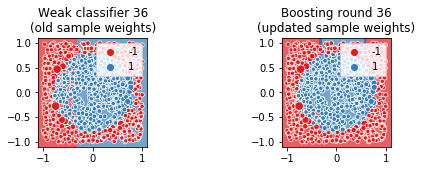

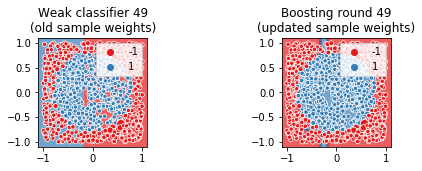

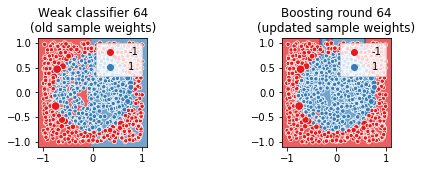

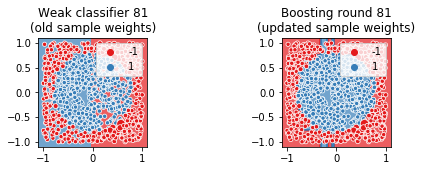

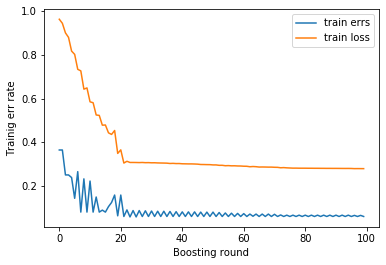

In [0]:
T = 100
W = np.ones(Y.shape)

grid_scores = 0
Y_scores = 0

H = []
train_errs = []
train_loss = []

XGrid, XGridFlat = get_grid(X)

for t in range(T):
    #f_t = linear_model.LogisticRegression(solver='lbfgs', C=1e6).fit(X, Y, W)
    f_t = tree.DecisionTreeClassifier(max_depth=1).fit(X, Y, W)
    #f_t = svm.LinearSVC().fit(X, Y, W)
    err_t = ((f_t.predict(X) != Y) * W).mean()
    if err_t > 0.5:
        print("No weak classifier found")
        break
    gamma_t = .5 * np.log((1-err_t) / err_t)
    H.append((gamma_t, f_t))
    W_old = W
    W = W_old * np.exp(- gamma_t * Y  * f_t.predict(X))

    grid_scores += gamma_t * f_t.predict(XGridFlat)
    Y_scores += gamma_t * f_t.predict(X)

    train_loss.append(np.exp(-Y_scores*Y).mean())
    train_errs.append((np.sign(Y_scores) != Y).mean())
    if np.ceil(np.sqrt(t)) != np.ceil(np.sqrt(t+1)):
        plt.figure(figsize=(8,2))
        plt.subplot(1, 2, 1)
        plot_data(X, Y, W_old, XGrid, f_t.predict(XGridFlat))
        plt.title(f'Weak classifier {t}\n(old sample weights)')
        
        plt.subplot(1, 2, 2)
        plot_data(X, Y, W_old, XGrid, np.sign(grid_scores))
        plt.title(f'Boosting round {t}\n(updated sample weights)')

plt.figure()
plt.plot(train_errs, label='train errs')
plt.plot(train_loss, label='train loss')
plt.xlabel('Boosting round')
plt.ylabel('Trainig err rate')
plt.legend()

# Real data example

In [0]:
german_df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric',
    names=[f'A{d}' for d in range(1,25)] + ['target'], header=None, sep='\s+')
# Targets are 1&2, change to -1&+1
german_df['target'] = german_df['target'] * 2 - 3

german_train_df, german_test_df = model_selection.train_test_split(german_df, test_size=0.3)
X = np.array(german_train_df[german_df.columns[:-1]])
Y = np.array(german_train_df['target'])

testX = np.array(german_test_df[german_df.columns[:-1]])
testY = np.array(german_test_df['target'])

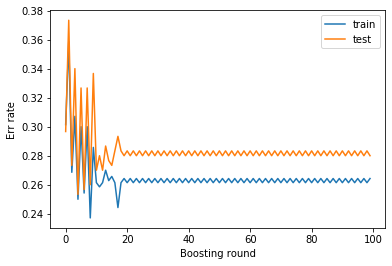

In [0]:
T = 100
W = np.ones(Y.shape)


H = []

Y_scores = 0
train_errs = []
train_loss = []

testY_scores = 0
test_errs = []

for t in range(T):
    f_t = tree.DecisionTreeClassifier(max_depth=1).fit(X, Y, W)
    err_t = ((f_t.predict(X) != Y) * W).mean()
    if err_t > 0.5:
        print("No weak classifier found")
        break
    gamma_t = .5 * np.log((1-err_t) / err_t)
    H.append((gamma_t, f_t))
    W *= np.exp(- gamma_t * Y  * f_t.predict(X))

    Y_scores += gamma_t * f_t.predict(X)
    train_errs.append((np.sign(Y_scores) != Y).mean())
    train_loss.append(np.exp(-Y_scores*Y).mean())

    testY_scores += gamma_t * f_t.predict(testX)
    test_errs.append((np.sign(testY_scores) != testY).mean())

plt.figure()
plt.plot(train_errs, label='train')
#plt.plot(train_loss, label='train loss')
plt.plot(test_errs, label='test')
plt.xlabel('Boosting round')
plt.ylabel('Err rate')
_ = plt.legend()

##Viola-Jones face recognizer

Viola-Jones is the first object detection framework to provied competetive object detection rates in real-time proposed in 2001 by Paul Viola and Michael Jones. It was motivated primarly to identify human faces in digital images.

##Details
The algorithm has four stages:


1.   Haar-like Feature Selection
2.   Creating an Integral Image
3.   AdaBoost Training
4.   Cascading Classifiers

## Haar-like Feature Selection
They are called Haar-like because they are similar to so called Haar wavelets which are sequences of rescaled "square-shaped" functions which can essentially be used to aproximate other functions. And really the similarity is basically that both things look like rectangles.

Mother function $\psi(t)$ of Haar wavelet can be described as
$$\psi(t) = \left\{ \begin{array} {l} 1 && 0 \leq t < \frac{1}{2} \\
-1 && \frac{1}{2} \leq t < 1 \\
0 && \text{otherwise}
  \end{array} \right.
$$

While the Haar-like features are black and white rectangular shapes that are used to match similarities of human faces






In [0]:
##Example Haar-like Feature 
!wget "https://upload.wikimedia.org/wikipedia/commons/6/69/Haar_Feature_that_looks_similar_to_the_eye_region_which_is_darker_than_the_upper_cheeks_is_applied_onto_a_face.jpg"

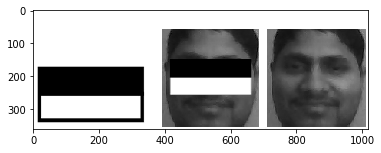

In [14]:
import cv2

img = cv2.imread("Haar_Feature_that_looks_similar_to_the_eye_region_which_is_darker_than_the_upper_cheeks_is_applied_onto_a_face.jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()
## Attribution - By Soumyanilcsc - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=37353395]

Haar-like feature in the above example is applied to the image, because in most humans the eye region is darker than upper cheeks

In [0]:
##Another example
!wget "https://upload.wikimedia.org/wikipedia/commons/8/8a/Haar_Feature_that_looks_similar_to_the_bridge_of_the_nose_is_applied_onto_the_face.jpg"

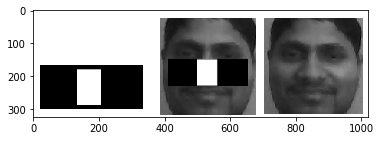

In [20]:
img = cv2.imread("Haar_Feature_that_looks_similar_to_the_bridge_of_the_nose_is_applied_onto_the_face.jpg")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()
## Attribution - By Soumyanilcsc - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=37353327

Here this Haar-like feature is used, because nose is brighter than cheeks

## Creating an Integral Image

Integral Image (also called summed-area table) lets us quickly and efficiently generate the sum of values in rectangular part of an image. 
The value at $(x,y)$ in the summed-area table is the sum of all the pixels above and to the left of $(x,y)$ inclusive
$$I(x,y) = \sum_{x' \leq x \\ y' \leq y }i(x', y')$$
where the $i(x,y)$ is the value of the pixel at $(x,y)$.

We can compute the $I(x,y)$ efficiently in a single pass over the image, because
$$I(x,y) = i(x,y) + I(x, y-1) + I(x-1, y) - I(x-1, y-1)$$

And now if we want to evaluate the sum of intensities over any rectangle we need just four array references. Let $A = (x_0,y_0)$ be a top left corner, $B = (x_1, y_0)$ top right corner, $C = (x_0, y_1)$ bottom right and $D = (x_1, y_1)$ bottom left. Then the sum $i(x,y)$ over the rectangle spanned by $A,B,C,D$ is
$$\sum_{x_0 \leq x \leq x_1 \\ y_0 \leq y \leq y_1} i(x,y) = I(D) + I(A) - I(B) - I(C)$$

That's one of the main reason why Viola and Jones were using such simple features like rectangles instead of something more sophisticated - it's very fast. Especially considering that each feature's rectangle is adjacent to at least one other rectangle, so we need just six array references for two rectangles, eight references for 3 rectangles and nine references for four rectangles.

## AdaBoost training

Unfortunately because the resolution of detector was $24 \times 24$ there were over $180,000$ rectangular feature to chose from. So the authors used AdaBoost algorithm to choose the best features.

##Cascading Classsifiers

The idea is to construct a cascade of more and more complex boosted classifiers, where smaller classifiers, which are more efficient, are first used to detect the sub-windows where there are no faces. Then the more complex classifiers are used to detect false positives not detected by weaker classfiers.